# Классификатор типов клеток

## 1. Входные данные
### Данные:

Данные представлены четырьмя образцами (sample_1, sample_2, …). Для каждого образца есть набор измерений определенных характеристик (маркеров) по каждой из клеток. Данные измерения представлены tsv файлами в папке дата. Строки соответствуют клеткам, столбцы – маркерам. Также, каждому образцу соответствует файл разметки, представленный tsv файлом в папке labels. Данный файл содержит названия типов клеток, которые будем считать ground truth.

### Задачи:
1. Построить и обучить произвольный классификатор типов клеток по всем образцам. Провести тестирование на тех же образцах, оценить качество распознавания. Качество распознавания оценить с помощью confusion matrix и f1-score.
2. Провести кросс-валидацию по файлам: взять первые три образца, обучить на них модель, тестировать на оставшемся образце (confusion matrix + f1-score). Далее взять следующие три образца, обучить на них и тестировать на оставшемся. На выходе должно быть четыре матрицы неточностей и четыре характеристики f1-score для каждого образца.
3. Выбрать образец с наивысшим f1-score. Провести снижение размерности данных до двух методом TSNE. Визуализировать результат классификации модели в двухмерном представлении.
4. Оценить качество кластеризации в двухмерном пространстве любым из существующих методов (например, Rand Index, Adjusted Rand Index, Mutual Information).

## 2. Загрузка данных

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

%matplotlib inline

pd.options.display.max_columns = None

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
df_sample_1_x = pd.read_csv('data/sample_1_x.tsv', delimiter='\t', index_col=0)
df_sample_2_x = pd.read_csv('data/sample_2_x.tsv', delimiter='\t', index_col=0)
df_sample_3_x = pd.read_csv('data/sample_3_x.tsv', delimiter='\t', index_col=0)
df_sample_4_x = pd.read_csv('data/sample_4_x.tsv', delimiter='\t', index_col=0)

In [3]:
df_sample_1_y = pd.read_csv('labels/sample_1_y.tsv', delimiter='\t', index_col=0)
df_sample_2_y = pd.read_csv('labels/sample_2_y.tsv', delimiter='\t', index_col=0)
df_sample_3_y = pd.read_csv('labels/sample_3_y.tsv', delimiter='\t', index_col=0)
df_sample_4_y = pd.read_csv('labels/sample_4_y.tsv', delimiter='\t', index_col=0)

In [4]:
from IPython.display import display

print('sample_1')
display(df_sample_1_x, df_sample_1_y)

print('sample_2')
display(df_sample_2_x, df_sample_2_y)

print('sample_3')
display(df_sample_3_x, df_sample_3_y)

print('sample_4')
display(df_sample_4_x, df_sample_4_y)

sample_1


,FSC-A,FSC-H,FSC-W,SSC-A,SSC-H,SSC-W,CD16,Viability_CD3_CD19_CD56_NKp46,FceRI,HLA-DR,CD64,CD45,CD14,CD9,CD169,CD15,CD36,CD206,CD14_max,CD15_max,CD16_max,CD169_max,CD206_max,CD36_max,CD45_max,CD64_max,CD9_max,FSC-A_max,FSC-H_max,FSC-W_max,FceRI_max,HLA-DR_max,SSC-A_max,SSC-H_max,SSC-W_max,Viability_CD3_CD19_CD56_NKp46_max,FSC-A_quantile,FSC-H_quantile,FSC-W_quantile,SSC-A_quantile,SSC-H_quantile,SSC-W_quantile,CD16_quantile,Viability_CD3_CD19_CD56_NKp46_quantile,FceRI_quantile,HLA-DR_quantile,CD64_quantile,CD45_quantile,CD14_quantile,CD9_quantile,CD169_quantile,CD15_quantile,CD36_quantile,CD206_quantile
0,2.460438,2.232254,1.580867,1.182881,1.037015,1.005976,6.972121,1.397368,1.030355,0.777716,2.578256,3.441088,1.924758,-0.366752,2.323447,4.702415,0.178137,-0.602118,0.185683,0.445063,0.433171,0.209457,-0.057747,0.015240,0.302763,0.209903,-0.036002,0.001444,0.851534,0.183452,0.084651,0.067726,0.019445,0.395588,0.120738,0.116049,0.580614,0.444011,0.225578,0.502347,0.416367,0.183529,1.298186,0.394510,0.278254,0.440077,1.082412,1.687780,1.139996,-0.101239,1.229947,3.047526,0.131775,-0.129076
1,2.732849,2.466566,1.701762,1.256693,1.095032,1.012745,6.594531,2.207393,1.519154,0.133268,2.007628,3.104673,0.515275,0.746190,0.895681,4.577778,-0.488935,0.186238,0.049709,0.433267,0.409711,0.080745,0.017861,-0.041830,0.273164,0.163447,0.073250,0.001604,0.940917,0.197481,0.124809,0.011605,0.020658,0.417720,0.121550,0.183320,0.644897,0.490618,0.242829,0.533693,0.439662,0.184764,1.227880,0.623200,0.410257,0.075411,0.842849,1.522776,0.305188,0.205981,0.474140,2.966752,-0.361684,0.039924
2,2.939153,2.579283,1.774919,1.638002,1.360035,1.212658,6.676904,2.547988,0.626683,1.996450,1.657572,3.595154,1.754127,1.571701,1.617930,4.752534,3.774703,-0.234991,0.169222,0.449807,0.414829,0.145855,-0.022537,0.322937,0.316319,0.134948,0.154287,0.001725,0.983915,0.205971,0.051486,0.173857,0.026926,0.518810,0.145544,0.211605,0.693581,0.513038,0.253268,0.695628,0.546062,0.221236,1.243217,0.719358,0.169240,1.129706,0.695887,1.763347,1.038935,0.433857,0.856473,3.080007,2.792293,-0.050375
3,2.125432,1.862580,1.575284,1.375635,1.151361,1.032410,6.711815,-0.293593,1.872281,-0.110308,2.369380,3.817016,0.133773,0.236639,2.137484,5.336497,0.663900,1.306427,0.012905,0.505076,0.416998,0.192693,0.125294,0.056799,0.335839,0.192898,0.023230,0.001247,0.710515,0.182804,0.153821,-0.009606,0.022613,0.439208,0.123910,-0.024382,0.501559,0.370480,0.224782,0.584205,0.462278,0.188352,1.249718,-0.082888,0.505621,-0.062419,0.994721,1.872165,0.079231,0.065323,1.131505,3.458460,0.491112,0.280059
4,2.597706,2.292351,1.618061,1.315767,1.116180,1.031997,6.653073,2.405819,-0.150439,1.264876,2.057008,3.383246,2.267851,0.097599,1.902689,4.349813,0.674993,0.219446,0.218781,0.411691,0.413348,0.171526,0.021046,0.057748,0.297674,0.167467,0.009581,0.001525,0.874459,0.187768,-0.012360,0.110149,0.021629,0.425787,0.123861,0.199799,0.613006,0.455965,0.230886,0.558781,0.448153,0.188276,1.238780,0.679220,-0.040627,0.715740,0.863580,1.659410,1.343204,0.026942,1.007213,2.819013,0.499319,0.047043
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,1.722213,1.572096,1.446478,1.071454,0.962770,0.937011,6.495367,-0.195028,1.118390,0.841751,1.736015,3.731200,2.133467,-1.017176,1.401323,3.678071,0.763897,0.398260,0.205817,0.348113,0.403550,0.126328,0.038196,0.065354,0.328289,0.141334,-0.099852,0.001011,0.599705,0.167857,0.091883,0.073302,0.017613,0.367266,0.112461,-0.016197,0.406407,0.312701,0.206402,0.455026,0.386558,0.170947,1.209416,-0.055061,0.302028,0.476311,0.728820,1.830074,1.263611,-0.280785,0.741809,2.383672,0.565084,0.085375
99996,1.706872,1.542747,1.266083,1.149332,1.017051,0.978258,6.708910,1.032981,0.808600,1.051486,1.923696,3.934241,1.313164,0.186481,1.478701,2.538822,0.162566,-0.432894,0.126682,0.240288,0.416818,0.133304,-0.041

,BG_population
0,Neutrophils
1,Neutrophils
2,MDSC
3,Neutrophils
4,Neutrophils
...,...
99995,Neutrophils
99996,Neutrophils
99997,Neutrophils
99998,T_cells


sample_2


,FSC-A,FSC-H,FSC-W,SSC-A,SSC-H,SSC-W,CD16,Viability_CD3_CD19_CD56_NKp46,FceRI,HLA-DR,CD64,CD45,CD14,CD9,CD169,CD15,CD206,CD36,CD14_max,CD15_max,CD16_max,CD169_max,CD206_max,CD36_max,CD45_max,CD64_max,CD9_max,FSC-A_max,FSC-H_max,FSC-W_max,FceRI_max,HLA-DR_max,SSC-A_max,SSC-H_max,SSC-W_max,Viability_CD3_CD19_CD56_NKp46_max,FSC-A_quantile,FSC-H_quantile,FSC-W_quantile,SSC-A_quantile,SSC-H_quantile,SSC-W_quantile,CD16_quantile,Viability_CD3_CD19_CD56_NKp46_quantile,FceRI_quantile,HLA-DR_quantile,CD64_quantile,CD45_quantile,CD14_quantile,CD9_quantile,CD169_quantile,CD15_quantile,CD206_quantile,CD36_quantile
0,1.062523,0.987108,1.114048,1.239466,1.125424,0.978361,5.554866,1.440057,-0.383957,1.360280,1.197406,2.647619,1.610359,-0.029464,2.016070,3.617881,1.145724,0.270310,0.155352,0.342417,0.345118,0.181747,0.109882,0.023126,0.232950,0.097484,-0.002892,0.000624,0.376550,0.129280,-0.031545,0.118458,0.020375,0.429314,0.117423,0.119594,0.250734,0.196343,0.158967,0.526377,0.451864,0.178491,1.034297,0.406563,-0.103690,0.769725,0.502699,1.298601,0.953784,-0.008133,1.067233,2.344665,0.847536,0.057946
1,0.108196,0.113400,0.660065,0.014560,0.015908,0.278271,0.040897,0.488714,-0.524139,1.053146,-0.241823,1.191930,-0.119628,2.210758,0.284063,0.064103,1.254999,5.139538,-0.011541,0.006067,0.002541,0.025608,0.120362,0.439702,0.104872,-0.019687,0.217020,0.000064,0.043259,0.076597,-0.043062,0.091711,0.000239,0.006068,0.033398,0.040587,0.025532,0.022556,0.094186,0.006183,0.006387,0.050768,0.007615,0.137976,-0.141547,0.595931,-0.101523,0.584616,-0.070853,0.610265,0.150372,0.041544,0.928371,1.101763
2,1.161923,1.082557,1.081864,1.676627,1.518745,1.242754,6.337686,1.428131,1.452384,1.209576,2.268469,3.495750,2.501729,-1.249470,2.091714,3.681130,0.927277,-0.167689,0.241344,0.348403,0.393754,0.188567,0.088932,-0.014346,0.307573,0.184682,-0.122655,0.000682,0.412961,0.125545,0.119323,0.105334,0.027561,0.579353,0.149156,0.118603,0.274190,0.215328,0.154374,0.712031,0.609785,0.226727,1.180056,0.403196,0.392225,0.684447,0.952356,1.714591,1.481725,-0.344908,1.107276,2.385655,0.685943,-0.035947
3,0.126546,0.134836,0.729898,0.028949,0.031197,0.401082,0.225694,-0.260477,-0.686030,1.272782,-0.086484,0.773493,0.567718,2.761877,0.893859,-0.315808,1.413542,5.122313,0.054768,-0.029890,0.014022,0.080581,0.135567,0.438229,0.068056,-0.007041,0.271121,0.000074,0.051436,0.084701,-0.056362,0.110838,0.000476,0.011901,0.048138,-0.021632,0.029862,0.026820,0.104151,0.012294,0.012526,0.073173,0.042023,-0.073539,-0.185267,0.720214,-0.036308,0.379382,0.336248,0.762397,0.473176,-0.204668,1.045652,1.098070
4,1.167238,1.090587,1.199412,1.176135,1.069641,0.975415,6.267788,1.519309,1.214036,0.469711,2.444319,3.285202,2.642405,-1.073823,0.917630,3.310858,0.681388,-0.371489,0.254915,0.313358,0.389411,0.082724,0.065349,-0.031782,0.289048,0.198999,-0.105412,0.000685,0.416025,0.139186,0.099741,0.040904,0.019334,0.408034,0.117070,0.126176,0.275445,0.216926,0.171147,0.499482,0.429467,0.177954,1.167041,0.428937,0.327858,0.265789,1.026183,1.611322,1.565045,-0.296421,0.485760,2.145690,0.504049,-0.079636
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,0.086228,0.091440,0.657805,0.016851,0.018770,0.305955,-0.273067,-0.257490,-0.853804,0.862195,0.282667,0.091389,0.008404,1.789408,0.500915,0.219135,0.637026,5.174258,0.000811,0.020740,-0.016965,0.045157,0.061095,0.442673,0.008041,0.023013,0.175658,0.000051,0.034881,0.076335,-0.070146,0.075083,0.000277,0.007160,0.036721,-0.021384,0.020348,0.018188,0.093864,0.007156,0.007536,0.055818,-0.050844,-0.072696,-0.230575,0.487880,0.118670,0.044824,0.004977,0.493954,0.265166,0.142016,0.471233,1.109206
99996,2.316943,1.269863,1.603170,1.188515,0.995619,1.154120,6.322914,5.073998,0.442875,1.528242,1.981132,5.520189,2.134846,0.333319,1.220824,3.821088,-1.387109,-1.097722,0.205950,0.361649,0.

,BG_population
0,Unidentified
1,Debris-2
2,Unidentified
3,Debris-2
4,Unidentified
...,...
99995,Debris-2
99996,Unidentified
99997,Classical_monocytes_CD9-
99998,Unidentified


sample_3


,FSC-A,FSC-H,FSC-W,SSC-A,SSC-H,SSC-W,CD16,Viability_CD3_CD19_CD56_NKp46,FceRI,HLA-DR,CD64,CD45,CD14,CD9,CD169,CD15,CD206,CD36,CD14_max,CD15_max,CD16_max,CD169_max,CD206_max,CD36_max,CD45_max,CD64_max,CD9_max,FSC-A_max,FSC-H_max,FSC-W_max,FceRI_max,HLA-DR_max,SSC-A_max,SSC-H_max,SSC-W_max,Viability_CD3_CD19_CD56_NKp46_max,FSC-A_quantile,FSC-H_quantile,FSC-W_quantile,SSC-A_quantile,SSC-H_quantile,SSC-W_quantile,CD16_quantile,Viability_CD3_CD19_CD56_NKp46_quantile,FceRI_quantile,HLA-DR_quantile,CD64_quantile,CD45_quantile,CD14_quantile,CD9_quantile,CD169_quantile,CD15_quantile,CD206_quantile,CD36_quantile
0,1.090543,0.904365,1.177486,0.136146,0.100605,0.738699,-1.516590,3.420060,-1.162821,4.257005,0.718267,5.083884,2.111433,3.763373,0.177478,0.269960,2.007309,4.226149,0.203691,0.025551,-0.094224,0.016000,0.192513,0.361559,0.447304,0.058476,0.369434,0.000640,0.344986,0.136641,-0.095534,0.370714,0.002238,0.038378,0.088659,0.284029,0.257346,0.179885,0.168019,0.057819,0.040393,0.134768,-0.282384,0.965565,-0.314027,2.408859,0.301545,2.493537,1.250560,1.038853,0.093950,0.174955,1.484884,0.905960
1,1.198122,1.102372,1.125469,1.895969,1.726928,1.280999,2.471533,3.282053,-1.043235,2.643069,0.270849,4.104159,1.987014,3.711119,2.392098,1.260555,2.805755,1.966312,0.191689,0.119306,0.153554,0.215646,0.269089,0.168224,0.361103,0.022051,0.364304,0.000703,0.420520,0.130605,-0.085709,0.230167,0.031167,0.658768,0.153746,0.272568,0.282732,0.219270,0.160596,0.805181,0.693371,0.233704,0.460191,0.926602,-0.281732,1.495601,0.113709,2.013003,1.176870,1.024429,1.266288,0.816937,2.075525,0.421518
2,1.279758,1.172123,1.267956,1.238901,1.110496,1.138749,6.985497,1.990868,-0.445556,1.243911,1.674931,3.578037,2.490985,0.579407,2.207692,3.903835,-0.703047,-0.614510,0.240307,0.369481,0.434002,0.199022,-0.067427,-0.052573,0.314813,0.136361,0.056878,0.000751,0.447128,0.147140,-0.036605,0.108324,0.020366,0.423619,0.136673,0.165338,0.301997,0.233144,0.180928,0.526137,0.445870,0.207752,1.300676,0.562070,-0.120325,0.703877,0.703175,1.754951,1.475362,0.159941,1.168671,2.529985,-0.520071,-0.131733
3,1.073223,0.990785,1.152328,1.319286,1.173422,1.002155,5.221361,1.630455,1.094153,-0.610483,0.931119,2.069897,2.218090,0.543450,1.570287,3.265614,-0.564688,0.360736,0.213981,0.309076,0.324398,0.141560,-0.054157,0.030862,0.182119,0.075805,0.053348,0.000630,0.377953,0.133722,0.089892,-0.053163,0.021687,0.447623,0.120279,0.135406,0.253259,0.197074,0.164429,0.560275,0.471136,0.182832,0.972200,0.460316,0.295483,-0.345446,0.390906,1.015240,1.313731,0.150016,0.831252,2.116369,-0.417722,0.077331
4,1.118483,1.023977,1.255371,0.735417,0.674185,0.902024,7.183543,-2.056080,1.896388,2.659290,2.086196,3.837679,2.187145,0.370141,-0.613703,4.855556,1.752523,0.659029,0.210995,0.459557,0.446306,-0.055325,0.168078,0.056382,0.337657,0.169843,0.036335,0.000656,0.390615,0.145680,0.155801,0.231580,0.012089,0.257180,0.108261,-0.170753,0.263939,0.203676,0.179132,0.312317,0.270689,0.164564,1.337552,-0.580480,0.512131,1.504779,0.875834,1.882300,1.295403,0.102175,-0.324872,3.146773,1.296409,0.141276
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,0.142447,0.149065,0.728468,0.015804,0.018162,0.284920,-1.179963,-0.247933,-0.601690,1.170567,-0.413219,0.289914,0.908607,2.724126,0.253749,-0.025750,1.211146,3.728971,0.087654,-0.002437,-0.073310,0.022875,0.116156,0.319024,0.025508,-0.033641,0.267415,0.000084,0.056864,0.084535,-0.049433,0.101937,0.000260,0.006928,0.034196,-0.020590,0.033615,0.029650,0.103947,0.006711,0.007292,0.051980,-0.219705,-0.069997,-0.162490,0.662374,-0.173479,0.142197,0.538150,0.751976,0.134325,-0.016688,0.895931,0.799379
99996,0.178630,0.183450,0.807878,0.023289,0.024619,0.349388,-0.850905,0.112655,-0.412717,1.391370,0.244644,0.598401,0.444054,3.130170,0.165303,0.200587,1.509460,3.528144,0.042838,0.018985,-0.05

,BG_population
0,Unidentified
1,Unidentified
2,Unidentified
3,Unidentified
4,Unidentified
...,...
99995,Debris-2
99996,Debris-2
99997,MDSC
99998,Unidentified


sample_4


,FSC-A,FSC-H,FSC-W,SSC-A,SSC-H,SSC-W,CD16,Viability_CD3_CD19_CD56_NKp46,FceRI,HLA-DR,CD64,CD45,CD14,CD9,CD169,CD15,CD206,CD36,CD14_max,CD15_max,CD16_max,CD169_max,CD206_max,CD36_max,CD45_max,CD64_max,CD9_max,FSC-A_max,FSC-H_max,FSC-W_max,FceRI_max,HLA-DR_max,SSC-A_max,SSC-H_max,SSC-W_max,Viability_CD3_CD19_CD56_NKp46_max,FSC-A_quantile,FSC-H_quantile,FSC-W_quantile,SSC-A_quantile,SSC-H_quantile,SSC-W_quantile,CD16_quantile,Viability_CD3_CD19_CD56_NKp46_quantile,FceRI_quantile,HLA-DR_quantile,CD64_quantile,CD45_quantile,CD14_quantile,CD9_quantile,CD169_quantile,CD15_quantile,CD206_quantile,CD36_quantile
0,1.150735,1.055971,1.203604,1.535753,1.321406,1.069490,6.852861,1.559912,0.198583,1.246203,1.134385,3.839971,2.798597,-1.393888,2.240041,4.786470,-0.157045,-0.205113,0.269983,0.453018,0.425761,0.201938,-0.015062,-0.017548,0.337859,0.092353,-0.136832,0.000675,0.402820,0.139672,0.016315,0.108523,0.025246,0.504075,0.128361,0.129548,0.271550,0.210040,0.171746,0.652205,0.530552,0.195117,1.275980,0.440400,0.053629,0.705173,0.476241,1.883424,1.657554,-0.384773,1.185795,3.102000,-0.116173,-0.043970
1,1.272315,1.187559,1.117659,1.137985,1.042042,0.977429,6.372719,1.335246,0.186506,1.017554,1.088354,3.715751,2.394801,-0.704746,0.269106,4.577239,-0.553245,0.455264,0.231028,0.433216,0.395930,0.024260,-0.053060,0.038949,0.326929,0.088606,-0.069182,0.000747,0.453016,0.129699,0.015323,0.088612,0.018707,0.397506,0.117312,0.110890,0.300241,0.236214,0.159482,0.483280,0.418386,0.178321,1.186579,0.376972,0.050367,0.575791,0.456916,1.822497,1.418394,-0.194540,0.142455,2.966402,-0.409257,0.097595
2,1.225112,1.104039,1.307395,1.227748,1.069443,1.203526,6.787471,0.688515,0.995837,0.041033,0.626887,4.139427,2.799976,0.671187,0.389021,4.161711,1.051075,1.316005,0.270116,0.393888,0.421699,0.035070,0.100805,0.112588,0.364206,0.051037,0.065887,0.000719,0.421156,0.151717,0.081815,0.003573,0.020182,0.407959,0.144448,0.057180,0.289102,0.219601,0.186556,0.521401,0.429388,0.219570,1.263804,0.194384,0.268932,0.023219,0.263182,2.030301,1.658371,0.185277,0.205933,2.697108,0.777521,0.282112
3,0.097052,0.097122,0.702514,0.011717,0.012424,0.215911,1.430705,0.024654,-1.106082,2.029361,1.001374,-0.194013,0.564502,3.139011,0.189359,0.366657,1.901785,4.964240,0.054458,0.034702,0.088888,0.017071,0.182393,0.424705,-0.017070,0.081525,0.308143,0.000057,0.037049,0.081523,-0.090872,0.176723,0.000193,0.004739,0.025914,0.002047,0.022902,0.019318,0.100244,0.004976,0.004988,0.039391,0.266393,0.006960,-0.298704,1.148329,0.420400,-0.095159,0.334343,0.866503,0.100239,0.237622,1.406824,1.064184
4,0.116549,0.118858,0.752507,0.023133,0.024640,0.358809,-0.974434,-0.676480,-1.316322,2.637861,1.340140,-0.025125,0.617727,3.896015,0.261038,0.203014,2.303881,5.538249,0.059593,0.019214,-0.060541,0.023532,0.220956,0.473813,-0.002211,0.109105,0.382454,0.000068,0.045341,0.087325,-0.108145,0.229713,0.000380,0.009399,0.043064,-0.056180,0.027503,0.023642,0.107377,0.009824,0.009893,0.065461,-0.181436,-0.190987,-0.355481,1.492653,0.562622,-0.012323,0.365868,1.075468,0.138184,0.131569,1.704269,1.187234
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,0.949770,0.902927,1.046775,1.138846,1.059215,0.971434,6.534675,0.904222,0.813728,1.277033,0.553283,3.606690,2.443433,-1.220354,2.461946,4.534127,1.541762,-0.084539,0.235720,0.429135,0.405993,0.221943,0.147865,-0.007233,0.317334,0.045044,-0.119797,0.000557,0.344438,0.121473,0.066853,0.111208,0.018721,0.404057,0.116592,0.075094,0.224126,0.179599,0.149367,0.483646,0.425281,0.177228,1.216735,0.255283,0.219752,0.722619,0.232281,1.769005,1.447198,-0.336870,1.303263,2.938463,1.140501,-0.018123
99996,0.230156,0.234093,0.877501,0.049305,0.040775,0.618194,0.877623,0.084729,-1.576007,2.915948,1.641741,0.858803,0.449063,4.185320,-0.112956,0.261520,2.835222,5.234984,0.043321,0.024752,0.054526,-0

,BG_population
0,Unidentified
1,Unidentified
2,Unidentified
3,Debris-2
4,Debris-2
...,...
99995,Unidentified
99996,Debris-2
99997,Unidentified
99998,Debris-2


## 3. Анализ данных

Для удобства добавим массивы

In [5]:
def get_df_samples():
    return {
        'sample_1' : (df_sample_1_x, df_sample_1_y),
        'sample_2' : (df_sample_2_x, df_sample_2_y),
        'sample_3' : (df_sample_3_x, df_sample_3_y),
        'sample_4' : (df_sample_4_x, df_sample_4_y)
    }

### Samples_x

Проверим пропуски

In [6]:
for name, (df_sample_i_x, df_sample_i_y)  in get_df_samples().items():
    print(name)
    print("NA counts: ", df_sample_i_x.isna().sum().sum())
    print()

sample_1
NA counts:  0

sample_2
NA counts:  0

sample_3
NA counts:  0

sample_4
NA counts:  0



Все ок, пропусков нет

Проверим, что во всех 4х файлах у нас содержатся одинаковый набор данных

In [7]:
def find_columns_diff_in_x(df_samples):
    has_diff = False
    
    for name_i, (df_sample_i_x, df_sample_i_y)  in df_samples.items():
        for name_j, (df_sample_j_x, df_sample_j_y)  in df_samples.items():
            
            cols_i = df_sample_i_x.columns
            cols_j = df_sample_j_x.columns
            
            has_diff_inner = False
            if len(cols_i) != len(cols_j):
                print(f"diff columns count: {name_i}-{name_j}: {len(cols_i)} != {len(cols_j)}")
                has_diff_inner = True
                
            col_num = 0
            for col_i, col_j in zip(cols_i, cols_j):
                if col_i != col_j:
                    print(f"diff col_num={col_num}: {name_i}-{name_j}: {col_i} != {col_j}")
                    has_diff_inner = True
                col_num+=1
                
            if has_diff_inner:
                has_diff = True
                print()
    
    return has_diff

print(f"Has diff: {find_columns_diff_in_x(get_df_samples())}")

diff col_num=16: sample_1-sample_2: CD36 != CD206
diff col_num=17: sample_1-sample_2: CD206 != CD36
diff col_num=52: sample_1-sample_2: CD36_quantile != CD206_quantile
diff col_num=53: sample_1-sample_2: CD206_quantile != CD36_quantile

diff col_num=16: sample_1-sample_3: CD36 != CD206
diff col_num=17: sample_1-sample_3: CD206 != CD36
diff col_num=52: sample_1-sample_3: CD36_quantile != CD206_quantile
diff col_num=53: sample_1-sample_3: CD206_quantile != CD36_quantile

diff col_num=16: sample_1-sample_4: CD36 != CD206
diff col_num=17: sample_1-sample_4: CD206 != CD36
diff col_num=52: sample_1-sample_4: CD36_quantile != CD206_quantile
diff col_num=53: sample_1-sample_4: CD206_quantile != CD36_quantile

diff col_num=16: sample_2-sample_1: CD206 != CD36
diff col_num=17: sample_2-sample_1: CD36 != CD206
diff col_num=52: sample_2-sample_1: CD206_quantile != CD36_quantile
diff col_num=53: sample_2-sample_1: CD36_quantile != CD206_quantile

diff col_num=16: sample_3-sample_1: CD206 != CD36
di

Видим, что колонки **CD36** и **CD206**, **CD36_quantile** и **CD206_quantile** переставлены местами в sample_1. Сравним их данные, чтобы определить в чем ошибка - колонки просто стоят в разном порядке, либо же поменяны названия колонок

#### Маркеры CD36 и CD206

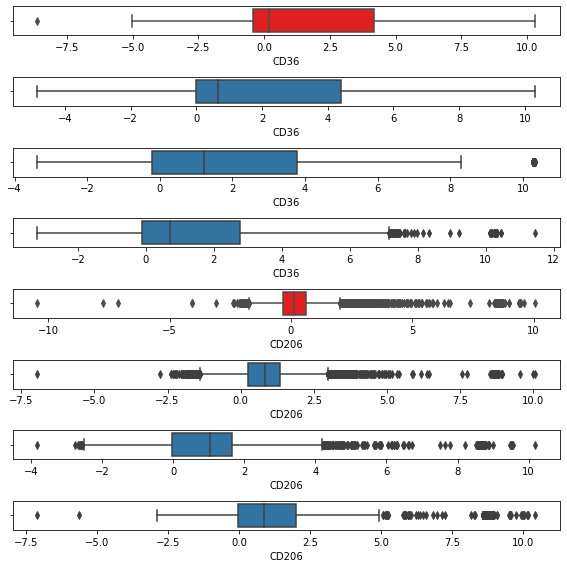

In [8]:
plt.figure(figsize=(8,8))
ax = plt.subplot(811)
sns.boxplot(data=df_sample_1_x, x='CD36', ax=ax, color='r')

ax = plt.subplot(812)
sns.boxplot(data=df_sample_2_x, x='CD36', ax=ax)

ax = plt.subplot(813)
sns.boxplot(data=df_sample_3_x, x='CD36', ax=ax)

ax = plt.subplot(814)
sns.boxplot(data=df_sample_4_x, x='CD36', ax=ax)


ax = plt.subplot(815)
sns.boxplot(data=df_sample_1_x, x='CD206', ax=ax, color='r')

ax = plt.subplot(816)
sns.boxplot(data=df_sample_2_x, x='CD206', ax=ax)

ax = plt.subplot(817)
sns.boxplot(data=df_sample_3_x, x='CD206', ax=ax)

ax = plt.subplot(818)
sns.boxplot(data=df_sample_4_x, x='CD206', ax=ax)

plt.tight_layout()

#### Маркеры CD36_quantile и CD206_quantile

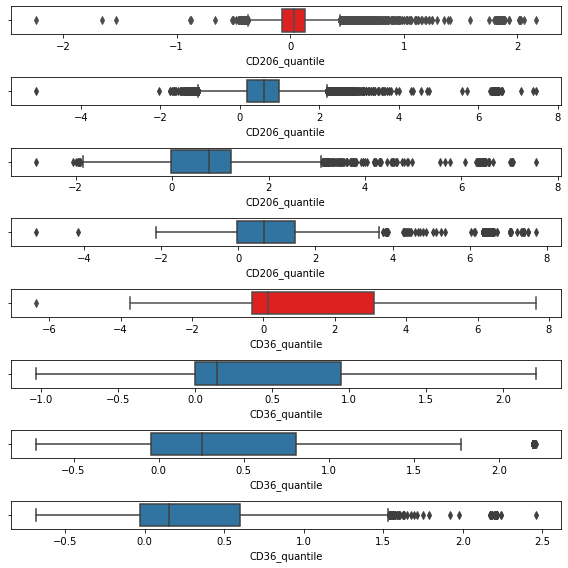

In [9]:
plt.figure(figsize=(8,8))

ax = plt.subplot(811)
sns.boxplot(data=df_sample_1_x, x='CD206_quantile', ax=ax, color='r')

ax = plt.subplot(812)
sns.boxplot(data=df_sample_2_x, x='CD206_quantile', ax=ax)

ax = plt.subplot(813)
sns.boxplot(data=df_sample_3_x, x='CD206_quantile', ax=ax)

ax = plt.subplot(814)
sns.boxplot(data=df_sample_4_x, x='CD206_quantile', ax=ax)

ax = plt.subplot(815)
sns.boxplot(data=df_sample_1_x, x='CD36_quantile', ax=ax, color='r')

ax = plt.subplot(816)
sns.boxplot(data=df_sample_2_x, x='CD36_quantile', ax=ax)

ax = plt.subplot(817)
sns.boxplot(data=df_sample_3_x, x='CD36_quantile', ax=ax)

ax = plt.subplot(818)
sns.boxplot(data=df_sample_4_x, x='CD36_quantile', ax=ax)

plt.tight_layout()

Видим, что данные в sample_1 в маркерах **CD36** и **CD206**, **CD36_quantile** и **CD206_quantile** по распределению похожи на данные в маркерах для других сэмплов. Отсюда делаем вывод, что колонки просто поменяны местами. Исправим это и еще раз проверим, что все ок

In [10]:
df_sample_1_x = df_sample_1_x[df_sample_2_x.columns]

print(f"Has diff: {find_columns_diff_in_x(get_df_samples())}")

Has diff: False


### Samples_y

Проверим пропуски

In [11]:
for name, (df_sample_i_x, df_sample_i_y)  in get_df_samples().items():
    print(name)
    print("NA counts: ", df_sample_i_y.isna().sum())
    print()
    

sample_1
NA counts:  BG_population    0
dtype: int64

sample_2
NA counts:  BG_population    0
dtype: int64

sample_3
NA counts:  BG_population    0
dtype: int64

sample_4
NA counts:  BG_population    0
dtype: int64



Все ок, пропусков нет

Взглянем на распределение типов клеток (наше target значение). Для удобства посмотрим датафрейм со всеми значениями из **samples_y**

In [12]:
df_population = pd.DataFrame()

for name, (df_sample_i_x, df_sample_i_y)  in get_df_samples().items():
    df_population_counts = pd.DataFrame(df_sample_i_y['BG_population'].value_counts())
    df_population_counts.columns=['BG_population_'+name]
    
    df_population = df_population \
        .merge(df_population_counts, left_index=True, right_index=True, how='outer') \
        .fillna(0)

df_population.sort_values(by=['BG_population_sample_1'], ascending=False, inplace=True)
df_population

,BG_population_sample_1,BG_population_sample_2,BG_population_sample_3,BG_population_sample_4
Neutrophils,36763.0,0.0,0.0,0.0
Unidentified,28919.0,71156.0,53870.0,75495.0
T_cells,11617.0,0.0,0.0,0.0
Dead_Neutrophils,9460.0,0.0,0.0,0.0
MDSC,4095.0,1788.0,1869.0,614.0
Classical_monocytes_CD9-,2272.0,3418.0,1635.0,960.0
B_cells,2246.0,0.0,0.0,0.0
Eosinophils,1370.0,0.0,0.0,0.0
Classical_monocytes_CD9+,1292.0,1317.0,491.0,315.0
Non-classical_monocytes,517.0,488.0,549.0,204.0


Видно, что у нас есть неравномерность в распределении данных - например в **sample_1_y** представлены почти все типы клеток, а в других наборах некоторых нет. Построим графики распределения

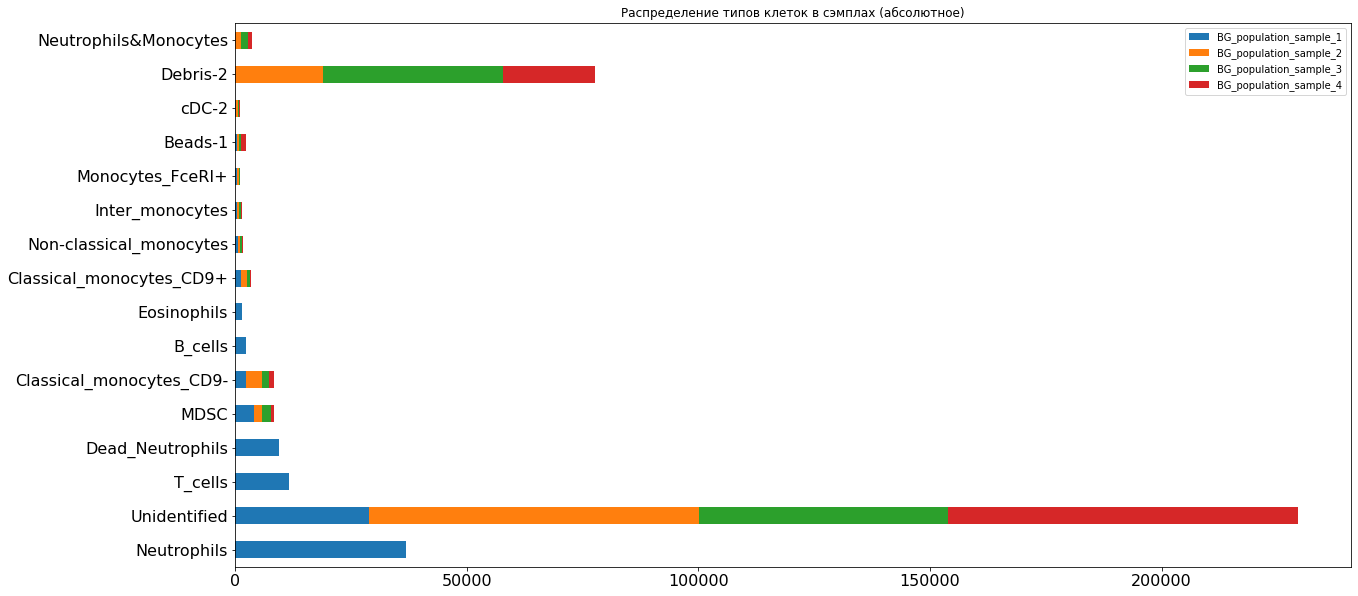

In [13]:
ax = df_population.plot.barh(figsize=(20,10), fontsize=16, stacked=True)
t = ax.set_title("Распределение типов клеток в сэмплах (абсолютное)")

По графику можно сделать следующие выводы:
- Во всех сэмплах примерно одинаковое количество **Unidentified** клеток и их довольно много в каждом сэмпле
- Клетоки **Debris-2** нет вообще в **sample_1**, а в остальных сэмплах их примерно одинаковое количество

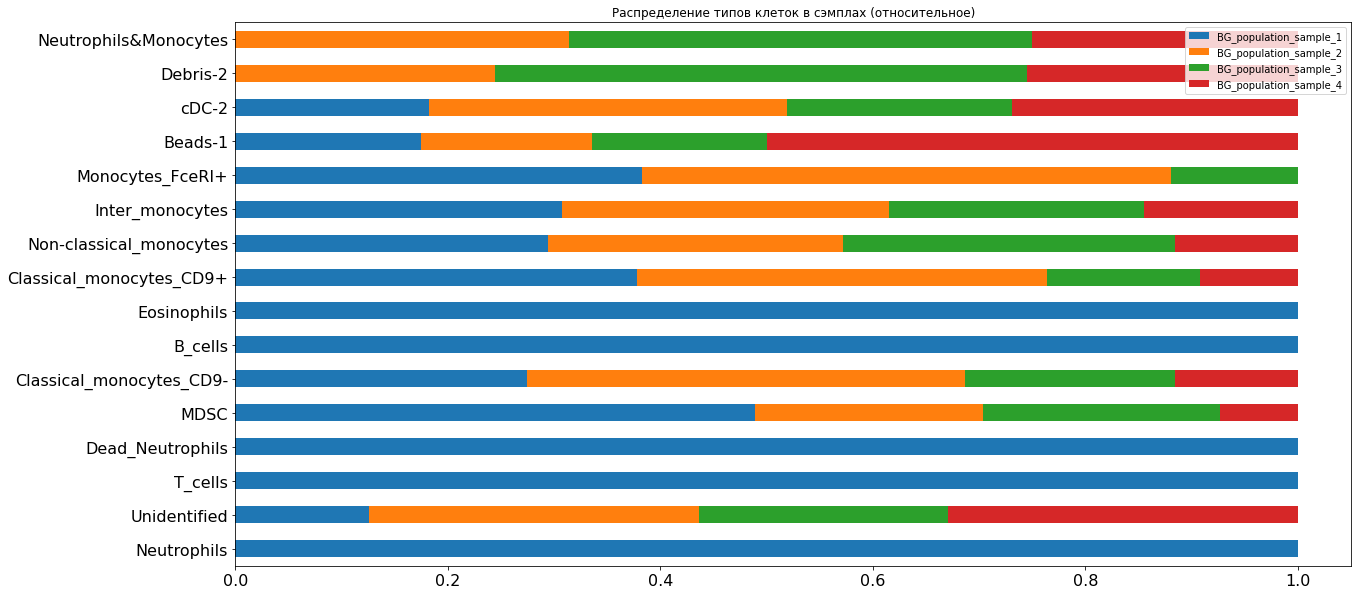

In [14]:
df_population = df_population.apply(lambda row: row / row.sum(), axis=1)
ax = df_population.plot.barh(figsize=(20,10), fontsize=16, stacked=True)
t = ax.set_title("Распределение типов клеток в сэмплах (относительное)")

Здесь выводы следующие:
- Клетки типов Neutrophils, T_cells, Dead_Neutrophils, B_cells, Eosinophils есть только в **sample_1**
- Клетки типов Debris-2, Neutrophils&Monocytes есть во всех **кроме sample_1**

### Выводы по анализу

- В данных нет пропусков
- Типы клеток распределены в сэмплаз очень неравномерно. Некоторые типы представлены не во всех сэплах, некоторые представлены только в одном из 4х. При кросс-валидации по сэмплах данный факт сильно скажется на качестве нашей модели

## 4. Построение модели и решение поставленных задач

### Подготовка данных для модели

Фукнция *get_frac* удобна для тестирование модели на небольшом количестве данных, чтобы долго не ждать. 

In [15]:
frac = 0.1

def get_frac(df_1, df_2, frac):
    frac_df_1, non_frac_df_1, frac_df_2, non_frac_df_2 = train_test_split(df_1, df_2, train_size=frac)

    frac_df_1.reset_index(drop=True, inplace=True)
    frac_df_2.reset_index(drop=True, inplace=True)
    
    return frac_df_1, frac_df_2

if frac is not None:
    df_sample_1_x, df_sample_1_y = get_frac(df_sample_1_x, df_sample_1_y, frac=frac)
    df_sample_2_x, df_sample_2_y = get_frac(df_sample_2_x, df_sample_2_y, frac=frac)
    df_sample_3_x, df_sample_3_y = get_frac(df_sample_3_x, df_sample_3_y, frac=frac)
    df_sample_4_x, df_sample_4_y = get_frac(df_sample_4_x, df_sample_4_y, frac=frac)

Создадим общий датасет со всеми данными, что у нас есть

In [16]:
def concat_dfs(df_samples):
    res_df_X = pd.DataFrame()
    res_df_y = pd.DataFrame()
    
    for name, (df_sample_i_x, df_sample_i_y)  in df_samples.items():
        res_df_X = res_df_X.append(df_sample_i_x)
        res_df_y = res_df_y.append(df_sample_i_y)
    
    res_df_X.reset_index(drop=True, inplace=True)
    res_df_y.reset_index(drop=True, inplace=True)

    return res_df_X, res_df_y


all_df_X, all_df_y = concat_dfs(get_df_samples())
all_y_true = all_df_y['BG_population'].values

all_df_X.shape, all_df_y.shape

((40000, 54), (40000, 1))

### Задача 1
*Построить и обучить произвольный классификатор типов клеток по всем образцам. Провести тестирование на тех же образцах, оценить качество распознавания. Качество распознавания оценить с помощью confusion matrix и f1-score.*

Для обучения возьмем KNeighborsClassifier. Обучим классификатор по всем образцам

In [17]:
%%time

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report, precision_score, f1_score, accuracy_score
from sklearn.neighbors import KNeighborsClassifier

knn_model = KNeighborsClassifier(n_neighbors=3)
knn_model.fit(all_df_X, all_y_true)

Wall time: 305 ms


KNeighborsClassifier(n_neighbors=3)

Протестим модель на всех образцах - посчитаем f1-score и построим матрицу ошибок. Значения в матрице ошибок нормализуем по количеству позитивных предсказаний (т.е. поделим на TP+FP). Таким образом значения в матрицу будут отображать *precision*

All data: f1_score=0.97820
Wall time: 23.9 s


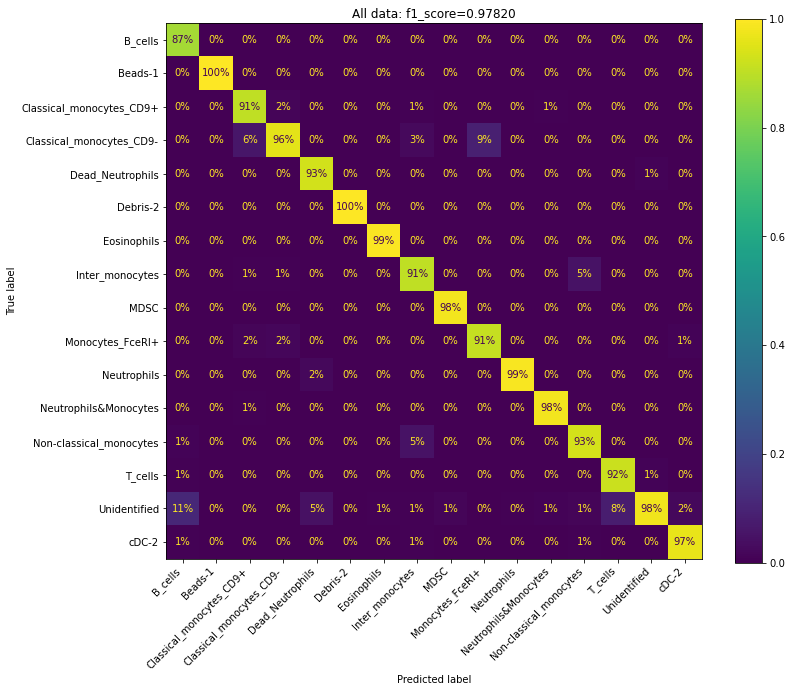

In [18]:
%%time

def calc_f1_score_and_plot_conf_matrix(name, model, df_X, y_true, ax, normalize='pred', colorbar=True):
    y_pred = model.predict(df_X)

    score = f1_score(y_true, y_pred, average='weighted')
    print(f"{name}: f1_score={score:.5f}")

    ConfusionMatrixDisplay.from_predictions(
        y_true, y_pred, labels=model.classes_,
        normalize=normalize,
        values_format='.0%',
        colorbar=colorbar,
        ax=ax
    )

    ax.set_title(f"{name}: f1_score={score:.5f}")
    
    for label in ax.get_xmajorticklabels():
        label.set_rotation(45)
        label.set_horizontalalignment("right")

plt.figure(figsize=(12, 10))
ax = plt.subplot()

calc_f1_score_and_plot_conf_matrix(
    "All data",
    knn_model,
    all_df_X,
    all_y_true,
    ax
)

Также проделаем тоже самое для каждого из образцов

sample_1: f1_score=0.94222
sample_2: f1_score=0.99203
sample_3: f1_score=0.99316
sample_4: f1_score=0.99479
Wall time: 25.3 s


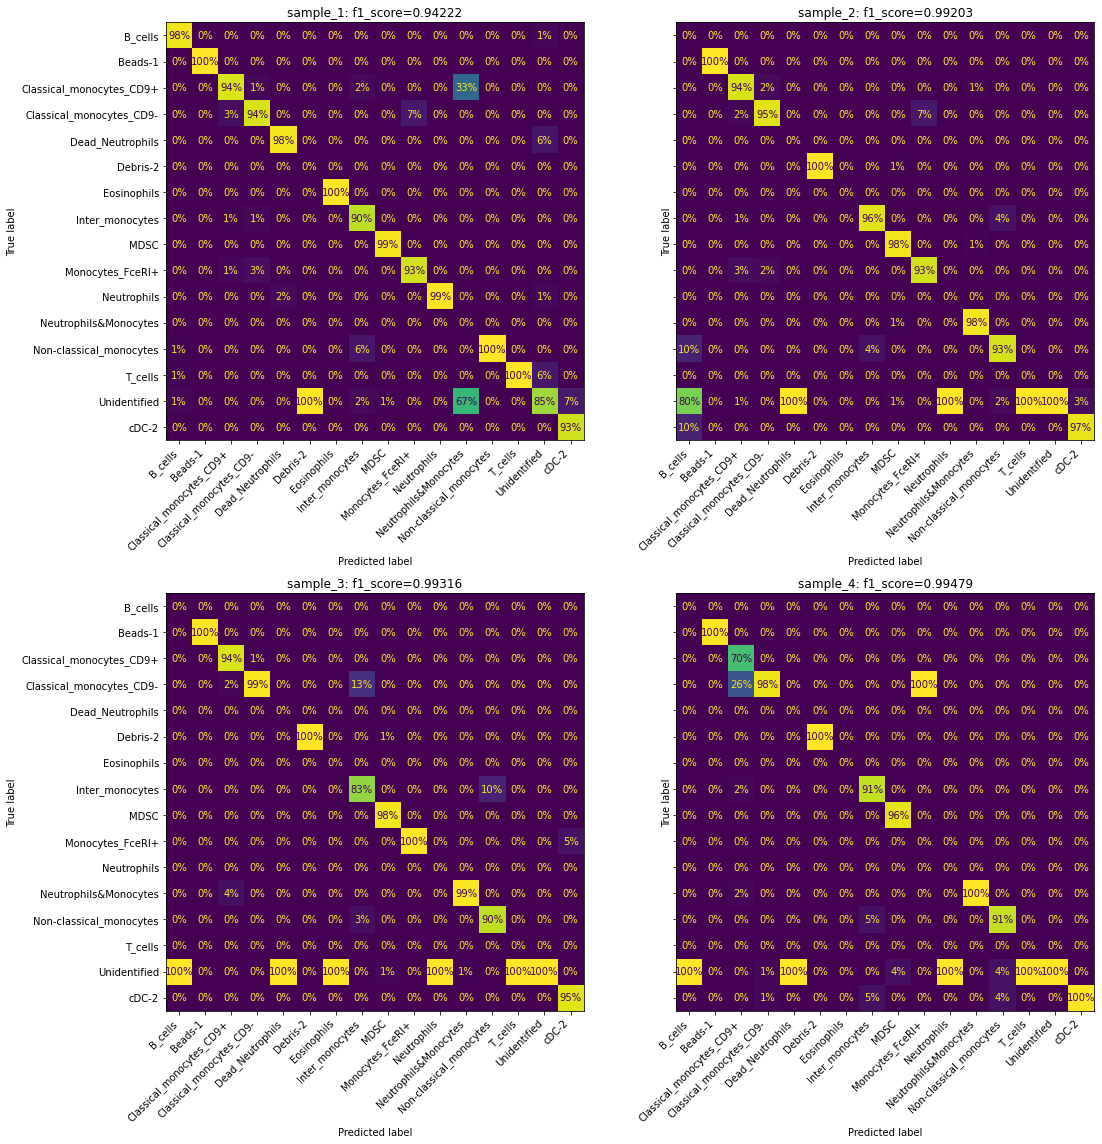

In [19]:
%%time

fig, axes = plt.subplots(2, 2, sharey=True, figsize=(16, 16))

for (name, (df_sample_i_x, df_sample_i_y)), ax  in zip(get_df_samples().items(), axes.ravel()):
    df_sample_i_x = df_sample_i_x
    y_true_i = df_sample_i_y['BG_population'].values
    
    calc_f1_score_and_plot_conf_matrix(
        name,
        knn_model,
        df_sample_i_x,
        y_true_i,
        ax,
        colorbar=False
    )

plt.tight_layout()

На общем фоне выделяется значени метрики для **Sample_1**. Построим *classification_report* для этого сэпмла

In [20]:
def print_classification_report(model, df_sample_x, df_sample_y):
    y_pred = model.predict(df_sample_x)
    y_true = df_sample_y['BG_population'].values

    cr = classification_report(y_true, y_pred, zero_division=0, digits=5, labels=model.classes_)
    print(cr)

print_classification_report(knn_model, df_sample_1_x, df_sample_1_y)

                          precision    recall  f1-score   support

                 B_cells    0.97605   0.78365   0.86933       208
                 Beads-1    1.00000   1.00000   1.00000        40
Classical_monocytes_CD9+    0.94483   0.96479   0.95470       142
Classical_monocytes_CD9-    0.94064   0.96714   0.95370       213
        Dead_Neutrophils    0.97791   0.80020   0.88018       996
                Debris-2    0.00000   0.00000   0.00000         0
             Eosinophils    1.00000   0.99351   0.99674       154
         Inter_monocytes    0.90196   0.92000   0.91089        50
                    MDSC    0.98630   0.97826   0.98226       368
        Monocytes_FceRI+    0.93103   0.75000   0.83077        36
             Neutrophils    0.99477   0.98421   0.98947      3674
   Neutrophils&Monocytes    0.00000   0.00000   0.00000         0
 Non-classical_monocytes    1.00000   0.84444   0.91566        45
                 T_cells    1.00000   0.81536   0.89829      1159
         

Видим, что для данного сэмпла у нас получился довольно низкий (относительно других классов) precison для *Unidentified*. Также довольно низкий и recall для *Dead_Neutrophils* и *T_cells*, так как модель их отнесла их к *Unidentified*

#### Вывод


```sh
F1-Score

All:      0.97838
Sample_1: 0.94448
Sample_2: 0.99152
Sample_3: 0.99258
Sample_4: 0.99492
```

Видим, что качество классификации получилось довольно хорошом. F1-score везде имеет результат близкий к 1. Из-за неравномерности данных Sample_1 имеет более низкий f1-score по отношению к другим сэмплам

### Задача 2
*Провести кросс-валидацию по файлам: взять первые три образца, обучить на них модель, тестировать на оставшемся образце (confusion matrix + f1-score). Далее взять следующие три образца, обучить на них и тестировать на оставшемся. На выходе должно быть четыре матрицы неточностей и четыре характеристики f1-score для каждого образца.*

train:{'sample_2', 'sample_3', 'sample_4'}, test:sample_1: f1_score=0.10940
train:{'sample_1', 'sample_3', 'sample_4'}, test:sample_2: f1_score=0.86028
train:{'sample_1', 'sample_2', 'sample_4'}, test:sample_3: f1_score=0.95185
train:{'sample_1', 'sample_2', 'sample_3'}, test:sample_4: f1_score=0.97759
Wall time: 21.5 s


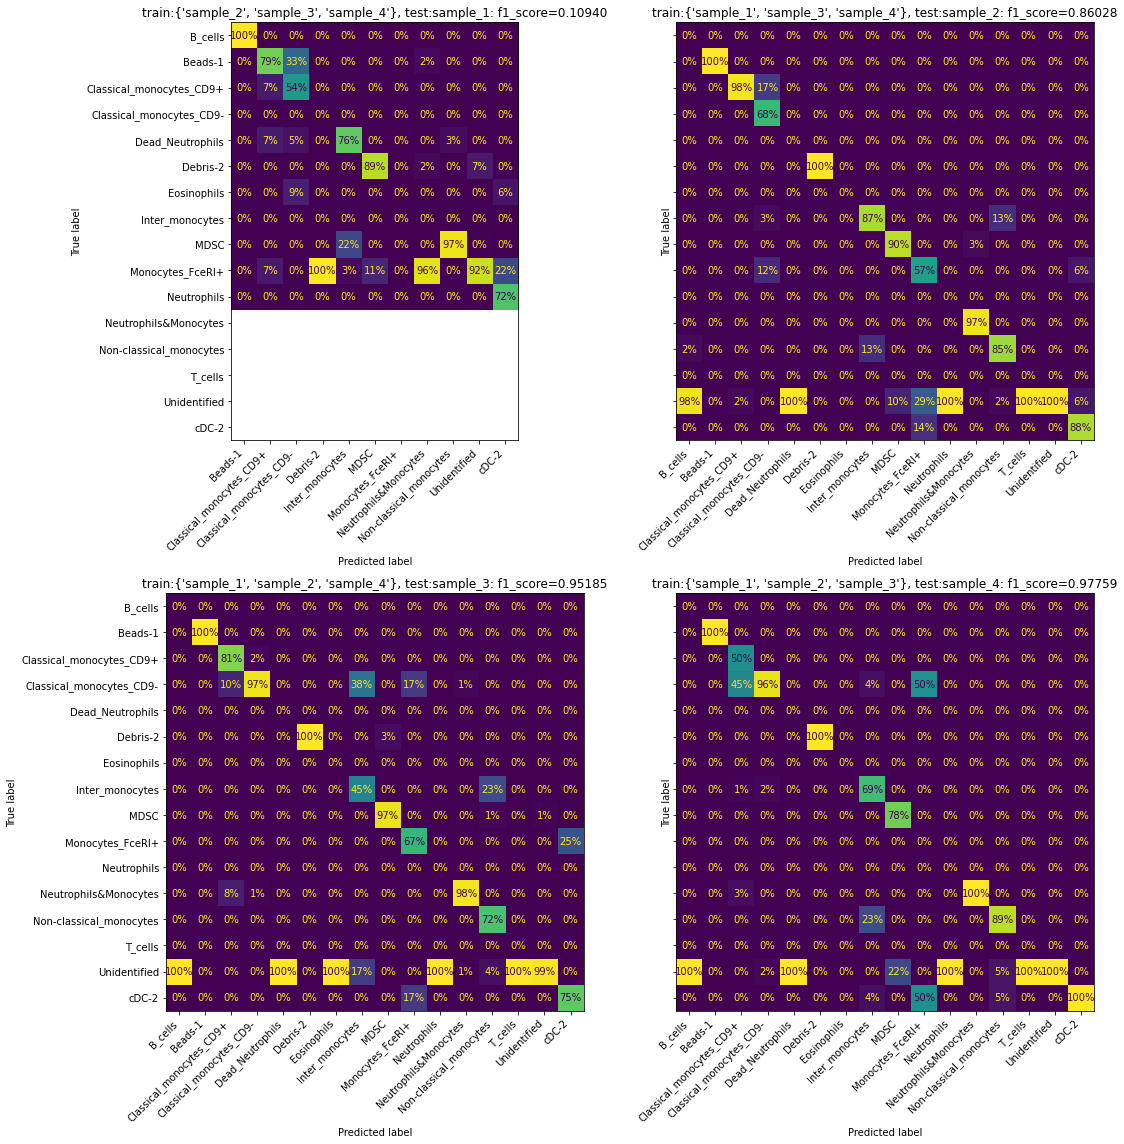

In [21]:
%%time

from sklearn.model_selection import KFold

models = {}
kf = KFold(n_splits=4)

fig, axes = plt.subplots(2, 2, sharey=True, figsize=(16, 16))

sample_names = set(get_df_samples().keys())
for (train_indexes, sample_i_indexes), df_sample, ax in zip(kf.split(all_df_X), get_df_samples().items(), axes.ravel()):
    train_X = all_df_X.iloc[train_indexes]
    train_y = all_y_true[train_indexes]
    
    # this is df_sample_i_x and sample_i_y
    test_X = all_df_X.iloc[sample_i_indexes].reset_index(drop=True)
    test_y = all_y_true[sample_i_indexes]
    
    model = KNeighborsClassifier(n_neighbors=3)
    model.fit(train_X, train_y)
    
    test_sample_name = df_sample[0]
    train_sample_names = sample_names.difference({test_sample_name})

    calc_f1_score_and_plot_conf_matrix(
        f"train:{train_sample_names}, test:{test_sample_name}",
        model,
        test_X,
        test_y,
        ax,
        colorbar=False
    )
    
    models[test_sample_name] = model

plt.tight_layout()

#### Вывод

```sh
F1-Score

train:{'sample_3', 'sample_2', 'sample_4'}, test:sample_1: 0.12099
train:{'sample_3', 'sample_1', 'sample_4'}, test:sample_2: 0.86940
train:{'sample_4', 'sample_1', 'sample_2'}, test:sample_3: 0.95288
train:{'sample_3', 'sample_1', 'sample_2'}, test:sample_4: 0.97776
```

Видим, что значения f1-score получились совершенно разные:
- Очень низкий для **sample_1** обусловлен тем, что есть несколько классов, которые есть только в нем и при кросс-валидации модель просто угадывала их.
- Напротив хороший показатель для **sample_4** обусловлен тем, что его классы есть во всех другим сэмплах, причем в равномерных количествах

### Задача 3
*Выбрать образец с наивысшим f1-score. Провести снижение размерности данных до двух методом TSNE. Визуализировать результат классификации модели в двухмерном представлении.*

Наивысший f1-score у нас получился в последнем случаем, когда обучались на 'sample_1', 'sample_3', 'sample_2' и тестировали 'sample_4'

In [22]:
model = models['sample_4']
df_sample_x, df_sample_y  = get_df_samples()['sample_4']

f1_score=0.97759


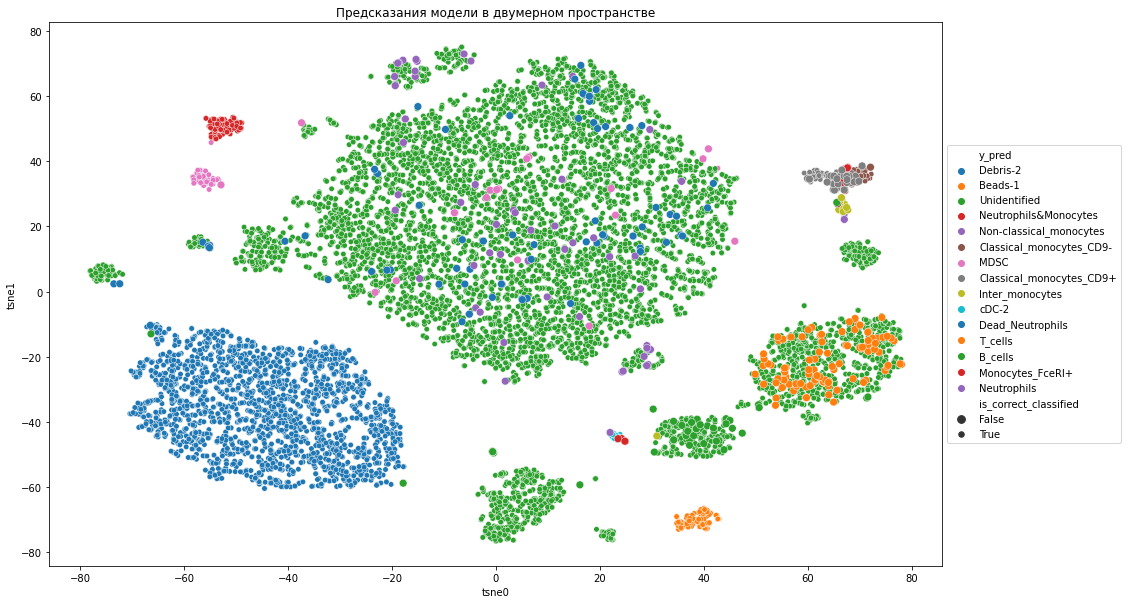

Wall time: 1min 28s


In [23]:
%%time

from sklearn.manifold import TSNE

def get_tsne_embedded(data, n_components=2):
    tsne = TSNE(n_components=n_components, random_state=27)
    data_embedded = tsne.fit_transform(data)
    
    return pd.DataFrame(data_embedded, columns=['tsne'+str(i) for i in range(n_components)])

def plot_tsne2(model, df_X, df_y):
    y_true = df_y['BG_population'].values
    y_pred = model.predict(df_X)
    
    # check f1-score again
    score = f1_score(y_true, y_pred, average='weighted')
    print(f"f1_score={score:.5f}")

    tsne_embedded = get_tsne_embedded(df_X, n_components=2)

    tsne_embedded['y_true'] = y_true
    tsne_embedded['y_pred'] = y_pred
    tsne_embedded['is_correct_classified'] = y_true == y_pred
    
    # Will sort to plot incorrect on the top
    sorted_tsne_embedded = tsne_embedded.sort_values(by='is_correct_classified', ascending=False)
    
    plt.figure(figsize=(16,10))
    ax = sns.scatterplot(data=sorted_tsne_embedded, x='tsne0', y='tsne1', hue='y_pred', \
                    size="is_correct_classified", sizes=(30, 60), marker='o', palette="tab10")
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.set_title("Предсказания модели в двумерном пространстве")

    plt.show()
    
    return tsne_embedded

df_tsne2 = plot_tsne2(model, df_sample_x, df_sample_y)

Для сравнения также добавим график для истинных значений меток

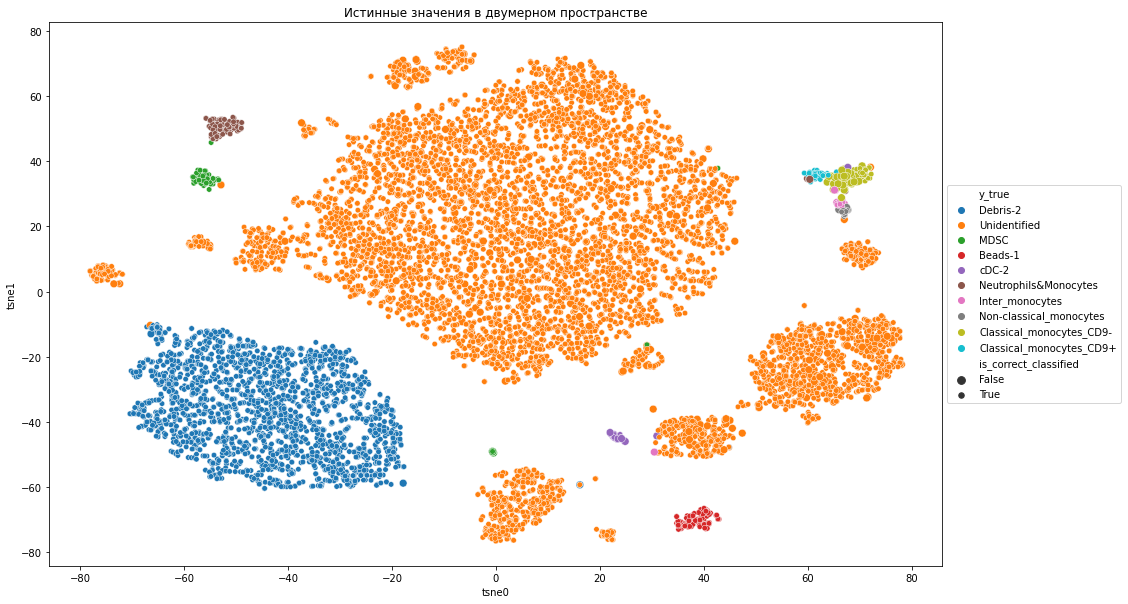

In [24]:
plt.figure(figsize=(16,10))
ax = sns.scatterplot(data=df_tsne2, x='tsne0', y='tsne1', hue='y_true', \
                size="is_correct_classified", sizes=(30, 60), marker='o', palette="tab10")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_title("Истинные значения в двумерном пространстве")

plt.show()

#### Вывод

Из графиков видно, что модель хорошо отделила кластера, однако есть много клеток, которые она ошибочно отнесла к 'Unidentified'

### Задача 4
*Оценить качество кластеризации в двухмерном пространстве любым из существующих методов (например, Rand Index, Adjusted Rand Index, Mutual Information).*

Построим метрики для оценки качества кластеризации. Помимо Rand Index и Mutual information для примера также посчитаем коэффициент силуата, так как для него не нужно знать истинных значений меток

In [25]:
%%time

from sklearn.metrics import rand_score, adjusted_rand_score, adjusted_mutual_info_score, silhouette_score, silhouette_samples

def calc_cluster_metrics(df_tsne2):
    metrics_df = pd.DataFrame(columns=['value'])
    
    y_true = df_tsne2['y_true']
    y_pred = df_tsne2['y_pred']
    df_tsne2_X = df_tsne2[['tsne0', 'tsne1']]
    
    metrics_df.loc['rand_score'] = rand_score(y_true, y_pred)
    metrics_df.loc['adjusted_rand_score'] = adjusted_rand_score(y_true, y_pred)
    metrics_df.loc['adjusted_mutual_info_score'] = adjusted_mutual_info_score(y_true, y_pred)
    metrics_df.loc['silhouette_score'] = silhouette_score(df_tsne2_X, y_pred)
    
    return metrics_df
    
calc_cluster_metrics(df_tsne2)

Wall time: 2.01 s


,value
rand_score,0.957003
adjusted_rand_score,0.912022
adjusted_mutual_info_score,0.876891
silhouette_score,-0.124709


Посмотрим на каждую метрику поотдельности:
- **Rand Index > 0.95**: значит наша разбиение по кластерам очень похоже на истинное разбиение (всего менее 5% пар клеток находятся разных кластерах, когда должны быть в однои и наоборот)
- **Adjusted Rand Index > 0.9**: наше разбинение гораздно лучше случайного
- **Adjusted Mutual Information > 0.87**: опять же горовот о том, что уровень вазимной информации между наших разбиение и истинным довольно большой и наше разбиение гораздно лучше случайного

Отдельно посмотрим на необычное значение для коэффициент силуэта:
- **Silhouette score ~-0.2**: Значение коэффициент силуэта около нуля горовит о перекрывающихся кластерах. Так как нам известно значение истинных меток, то посмотрим на коэффициент силуэта для них. Смотря на графики ниже видно, что для истинного разбиения этот коэффициент имеет значение бликое к 0 - все из-за того, что у нас довольно много данных типа 'Unidentified', которые визуально должны быть в разных кластерах. Поэтому данный коэффициент для наших данных не очень информативен.

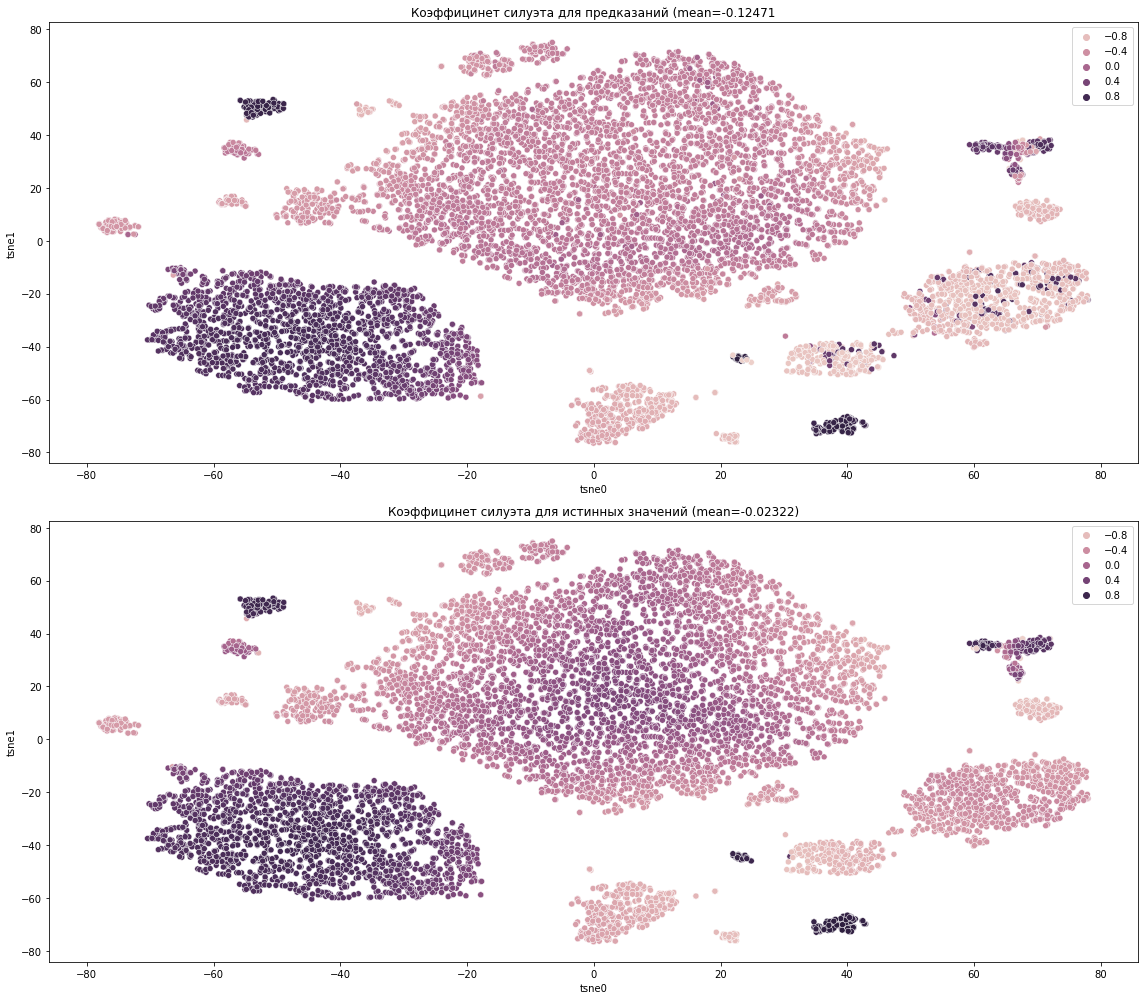

In [26]:
def plot_silhouette(df_tsne2):
    silhouette_true = silhouette_samples(df_tsne2[['tsne0', 'tsne1']], df_tsne2['y_true'])
    silhouette_pred = silhouette_samples(df_tsne2[['tsne0', 'tsne1']], df_tsne2['y_pred'])

    fig, axes = plt.subplots(2, 1, figsize=(16,14))

    sns.scatterplot(data=df_tsne2, x='tsne0', y='tsne1', ax=axes[0], hue=silhouette_pred)
    axes[0].set_title(f"Коэффицинет силуэта для предказаний (mean={silhouette_pred.mean():.5f}")

    sns.scatterplot(data=df_tsne2, x='tsne0', y='tsne1', ax=axes[1], hue=silhouette_true)
    axes[1].set_title(f"Коэффицинет силуэта для истинных значений (mean={silhouette_true.mean():.5f})")

    plt.tight_layout()
    plt.show()
    
plot_silhouette(df_tsne2)

#### Вывод

Высокие значения посчитанных метрик говорит нам о том, что разбиение по кластерам очень похоже на истинное разбиение